# Advanced Statistics for Quantitative Trading
<div class="alert alert-info"><strong>Part II : Time Series Modeling with Python</strong></div>

#### Notebook Created on: 6 July 2020
##### Last Update: 8 Jul 2022
##### Version 3.5
##### Author: Vivek Krishnamoorthy

## **Agenda for today**

- Modeling time series using decomposition
    - A fleeting exploration of oil price seasonality
    - Method I: `statsmodels` library
    - Method II: `fbprophet` library
- Testing for stationarity
- Modeling time series using
    - Method III: ARIMA
- A brief glance at modeling volatility using ARCH/GARCH

<a id = 'convert'></a>

### Anatomy of a time series process

Time series processes have a wide variety of patterns. So it is helpful to consider them as a combination of *systematic* and *unsystematic* components.

- **Systematic**: These are recurring in nature and so can be described and modeled.
- **Non-systematic**: These are random in nature and so cannot be directly modeled.

The systematic components can be further split into *level*, *trend*, and *seasonality* whereas the non-systematic component is referred to as *noise*.

- **Level**: The average value of the process.
- **Trend**: The direction and rate of change of the process. The slope is a good proxy for it.
- **Seasonality**: Deviations in the process caused by recurring short-term cycles.
- **Noise**: The random variation observed in the process.

Another useful abstraction while analyzing time series processes is to see them as either an *additive* or a *multiplicative* blend of the four constituent parts mentioned.

**Additive model**: The process $X(t)$ has the form
$$X(t) = Level + Trend + Seasonality + Noise$$

We use an additive model when the underlying process under examination has the following characteristics.
- The process changes remain constant over time (i.e. they are linear). So the trend line would be straight.
- It shows linear seasonality. That is to say the frequency and amplitude (i.e. the width and the height) of the cycles remain constant over time.



**Multiplicative model**: The process $X(t)$ has the form
$$X(t) = Level \times Trend \times Seasonality \times Noise$$

We use a multiplicative model when the underlying process under examination has the following characteristics.
- The process changes vary over time (i.e. they are non-linear in nature).
- An exponential or quadratic or higher order polynomial process is multiplicative. So the trend-line would be curved, not straight. 
- It shows non-linear seasonality. That is to say the frequency and amplitude (i.e. the width and the height) of the cycles vary over time.

In the (harsh) real world, we often encounter non-linear or even mixed processes and therefore have to work with the multiplicative model as our prototype. But we prefer to work with linear processes as they are easier to use. So we transform the original process into a linear one. A commonly used trick is applying a log transformation.

### Modelling a time series using decomposition

There are several available libraries (ex. [`statsmodels`](https://www.statsmodels.org/stable/tsa.html), [`prophet`](https://facebook.github.io/prophet/docs/quick_start.html), [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), [`PyFlux`](https://pyflux.readthedocs.io/en/latest/), [`fecon236`](https://github.com/MathSci/fecon236), [`PM-Prophet`](https://github.com/luke14free/pm-prophet) at the time of this writing) in Python to develop sophisticated time series models for forecasting. 

We work with `statsmodels` and `prophet` here. Both offer convenient routines to automatically decompose a time series into their fundamental components.

To illustrate the ideas, we make use of the daily historical prices of crude oil (from 2003 to 2022) and soybean (from 2000 to 2020).

> *The OPEC Reference Basket (ORB), also referred to as the OPEC (Organization of Petroleum Exporting Countries ex. Qatar, Saudi Arabia, Iran, Iraq) Basket, is a weighted average of prices for petroleum blends produced by OPEC members. It is used as an important benchmark for crude oil prices. The OPEC Basket, including a mix of light and heavy crude oil products, is heavier than both Brent crude oil, and West Texas Intermediate crude oil.* - [Source](https://www.investopedia.com/terms/o/opecbasket.asp)

> *The soya bean is a species of legume and is one of the world’s most important oil plants, since around half of vegetable oil produced is obtained from the soya bean. It is particularly significant because of its protein content (39 per cent) and its oil content (17 per cent), since no other plant offers comparable values. Soya is also used as an ingredient and additive in the food industry. It is estimated that around 30,000 foods contain ingredients derived from soya. Soya milk can be produced from ground yellow soya beans, and then can be processed into tofu. Tofu is used as a meat substitute in vegetarian cookery because of its high protein content and because it contains all the essential amino acids.* - [Source](https://markets.businessinsider.com/commodities/soybeans-price/usd)







We first try the `seasonal_decompose` method from the `statsmodels.tsa` sub-library and then experiment with the `fbprophet` library.

#### Method I : Seasonal decomposition using the `seasonal_decompose` routine in `statsmodels` 

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

import nasdaqdatalink
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

In [2]:
end4 = datetime.date(2022, 6, 30)
start4 = datetime.date(2003, 1, 1)

ticker4 = "OPEC/ORB"

In [3]:
## ***********************************************************
## ***** EXPERIMENTAL : IGNORE THIS CELL *********************
## Trials with other commodity data
## ***********************************************************

# "OPEC/ORB" this is crude oil prices per barrel
# WGC/GOLD_DAILY_INR for daily gold prices in India available until 10 March 2020
# TFGRAIN/SOYBEANS for daily soy bean prices per bushel
# WORLDAL/PALPROD primary aluminium production across continents. not tried.

In [4]:
df = nasdaqdatalink.get(dataset=ticker4, start_date=start4, end_date=end4)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker4} data")

Downloaded 5030 rows and 1 columns of OPEC/ORB data


In [5]:
df4 = df.copy()

In [6]:
print(df4.head(10))
print(df4.tail())

            Value
Date             
2003-01-02  30.05
2003-01-03  30.83
2003-01-06  30.71
2003-01-07  29.72
2003-01-08  28.86
2003-01-09  29.51
2003-01-10  29.82
2003-01-13  29.82
2003-01-14  30.21
2003-01-15  30.66
             Value
Date              
2022-06-24  112.35
2022-06-27  114.88
2022-06-28  117.55
2022-06-29  117.63
2022-06-30  115.60


In [7]:
df4.rename(columns={'Value': 'price'}, inplace=True)

In [8]:
oil_long_run_mean = np.round(df4['price'].mean(), 1)
print(oil_long_run_mean)

68.6


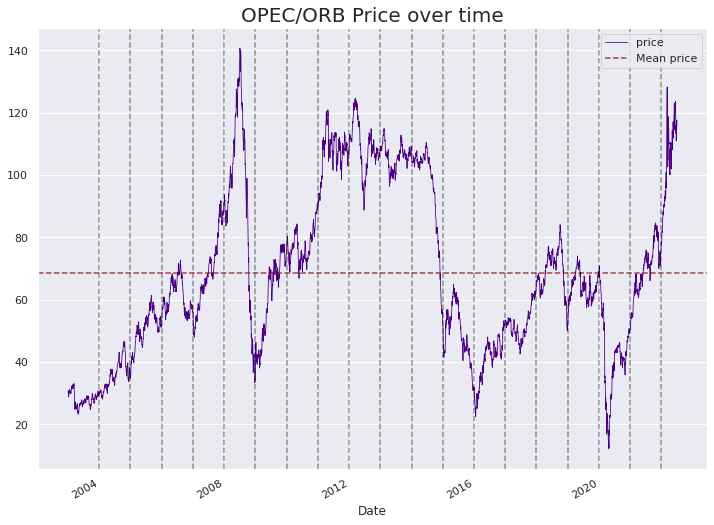

In [9]:
df4.plot(figsize=(12, 9), linewidth=0.8, color='indigo')
plt.title(f"{ticker4} Price over time", fontsize=20)
for eachyear in range(start4.year, end4.year):
    plt.axvline(pd.to_datetime(str(eachyear)+'-12-31'), color='black', linestyle='--', alpha=0.4)

plt.axhline(df4['price'].mean(), label='Mean price', color='maroon', linestyle='--', alpha=0.7)
plt.legend()

Points to note:
- There are upward and downward trends in the prices. Looks linear. Needs further probing.
- There seems to be seasonality and we can investigate further by looking at some moving averages.

In [10]:
window_length = 21 # for 1 monthly moving average calculations
window_length2 = 252 # for annual moving average calculations

## Calculating 21-day rolling mean and volatility

df4['rolling_21d_mean'] = df4['price'].rolling(window=window_length).mean()
df4['rolling_21d_vol'] = df4['price'].rolling(window=window_length).std()


## Calculating 252-day rolling mean and volatility

df4['rolling_12m_mean'] = df4['price'].rolling(window=window_length2).mean()
df4['rolling_12m_vol'] = df4['price'].rolling(window=window_length2).std()

Text(0, 0.5, 'Price per barrel (in US$)')

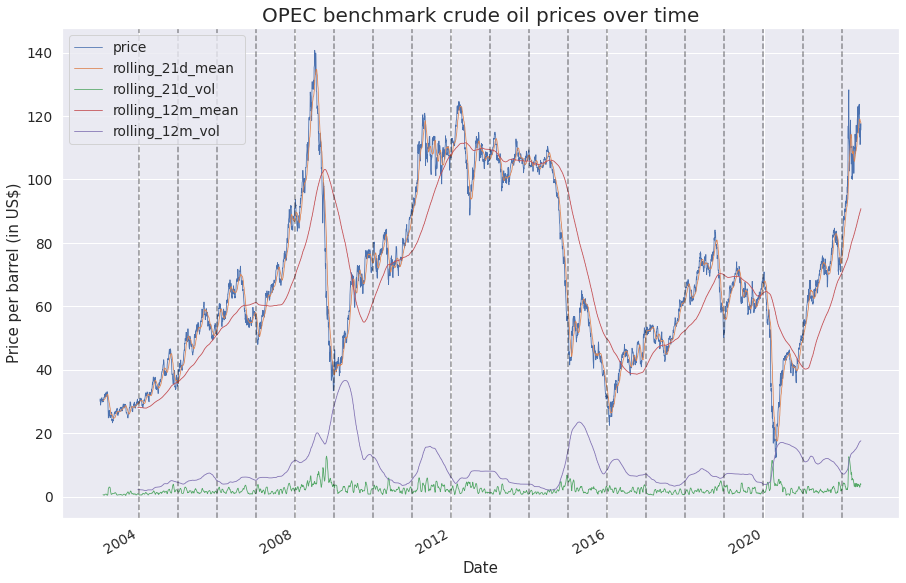

In [11]:
sns.set(font_scale=1.25)
df4.plot(figsize=(15, 10), linewidth=0.8)

for eachyear in range(start4.year, end4.year):
    plt.axvline(pd.to_datetime(str(eachyear)+'-12-31'), color='black', linestyle='--', alpha=0.4)


plt.title("OPEC benchmark crude oil prices over time", fontsize=20)
plt.xlabel("Date")
plt.ylabel("Price per barrel (in US$)")

Points to note:
- The yearly moving average of the prices show a linear trend (which changes roughly every couple of years).
- The monthly moving price average shows seasonality.
- The rolling volatility is time-varying in both (monthly and annual) cases.
- Let's try using the **multiplicative** model.

## A fleeting exploration of oil price seasonality

In [12]:
df4x = df.copy()

In [13]:
df4x.head()

,Value
Date,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86


In [14]:
df4x = df4x.resample("M").mean()

In [15]:
df4x.rename(columns={'Value': 'monthly_mean_price'}, inplace=True)

In [16]:
df4x['year_'] = df4x.index.year

In [17]:
df4x['month_'] = df4x.index.month_name().str[:3]

In [18]:
df4x.tail()

,monthly_mean_price,year_,month_
Date,,,
2022-02-28,93.954000,2022,Feb
2022-03-31,113.476522,2022,Mar
2022-04-30,105.636500,2022,Apr
2022-05-31,113.870909,2022,May
2022-06-30,117.723636,2022,Jun


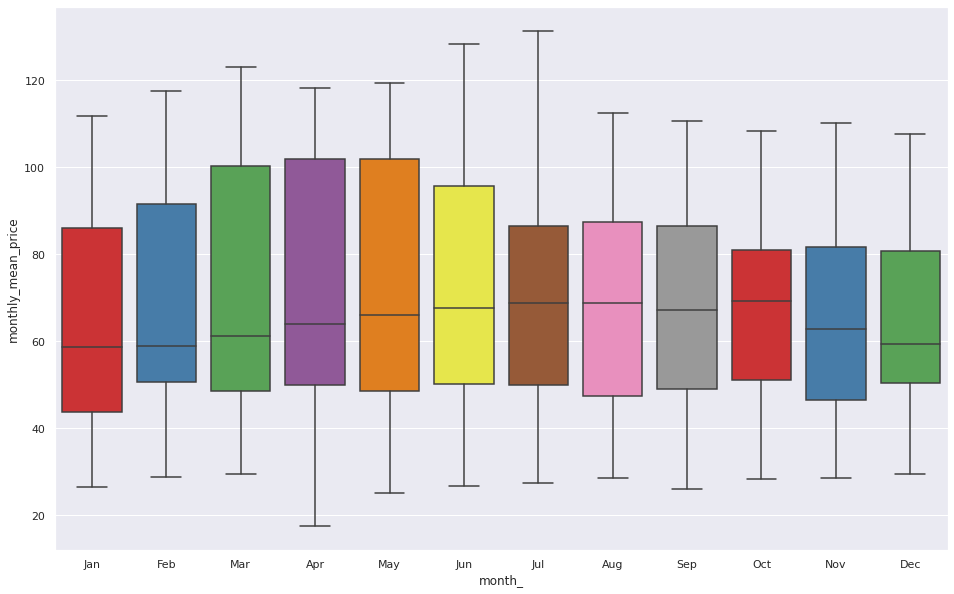

In [19]:
# define figure size with width = 16 and height = 10

sns.set(rc={"figure.figsize":(16, 10)})

# box plot grouping by month to check for trend changes monthly

df4xbox = sns.boxplot(x='month_', y='monthly_mean_price', data=df4x, 
                   order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                   palette='Set1')

In [20]:
## Method I: Using statsmodels

decompose_series = seasonal_decompose(df4['price'], period=252, model="multiplicative")

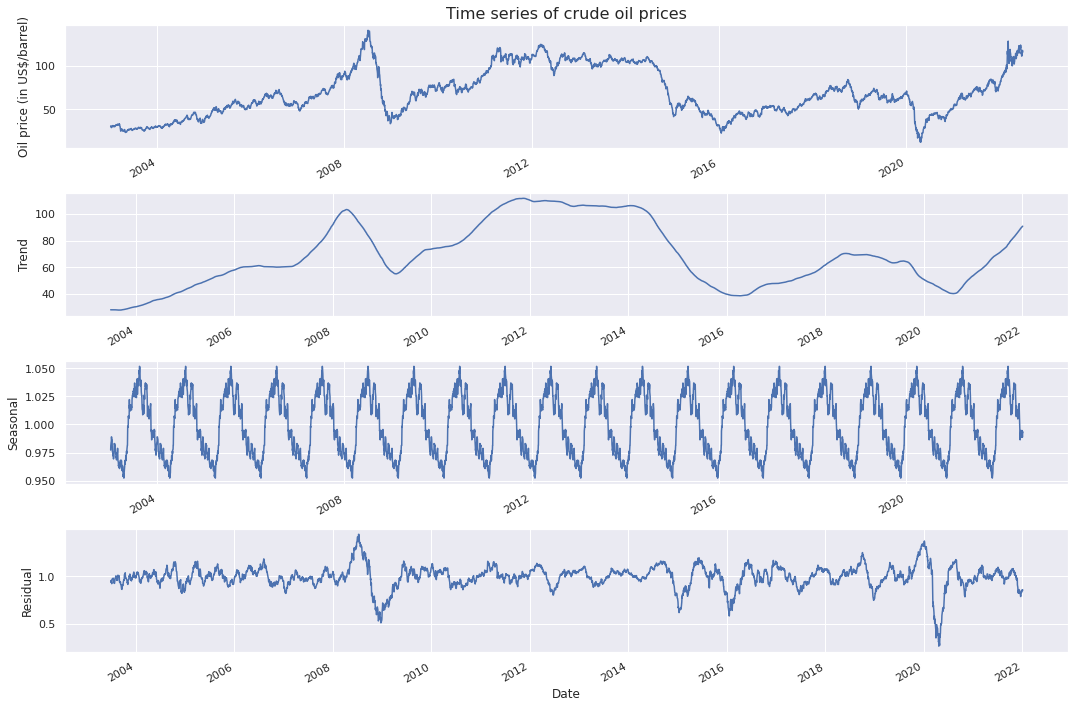

In [21]:
fig, ax = plt.subplots(4, 1, figsize=(15, 10))

decompose_series.observed.plot(ax=ax[0])
ax[0].set_title("Time series of crude oil prices", fontsize=16)
ax[0].set(xlabel="", ylabel="Oil price (in US$/barrel)")


decompose_series.trend.plot(ax=ax[1])
ax[1].set(xlabel="", ylabel="Trend")


decompose_series.seasonal.plot(ax=ax[2])
ax[2].set(xlabel="", ylabel="Seasonal")


decompose_series.resid.plot(ax=ax[3])
ax[3].set(xlabel="Date", ylabel="Residual")


plt.tight_layout()

In [26]:
decompose_series.seasonal

Date
2003-01-02    0.977159
2003-01-03    0.981190
2003-01-06    0.984329
2003-01-07    0.984400
2003-01-08    0.988983
                ...   
2022-06-24    0.994676
2022-06-27    0.992479
2022-06-28    0.988674
2022-06-29    0.993757
2022-06-30    0.992580
Name: seasonal, Length: 5030, dtype: float64

Points to note:
- The plot shows us the observed, trend, seasonal and residual time series. We can access each component by typing: `decompose_series.trend`, `decompose_series.seasonal`, and `decompose_series.residual` 
- The trend and seasonal plots that have been extracted from the original series look plausible.
- The residual plot clearly has non-constant volatility. If the model was a suitable fit, then after taking out the trend and seasonality present in the price data, we would have residuals that do not have any discernable pattern. Not so here.
- At this stage, we would evaluate alternatives to model the residuals. We could even consider exogenous variables like oil production, renewable energy investments, etc. which would influence oil prices (outside the scope of this session).
- From the `statsmodels` documentation: *This is a naive decomposition. More sophisticated methods should be preferred.*

#### Method II : Seasonal decomposition using Facebook's Prophet library `fbprophet`

We use the daily soybean prices from 2000 through 2018 to fit the model and make forecasts for the period from January 2019 to Feb 2020.

In [22]:
## Method II: Using fbprophet
## Working with the soy bean price series

from prophet import Prophet

In [23]:
start5 = '2000-12-01'
end5 = '2022-03-15'
ticker5 = "TFGRAIN/SOYBEANS"

In [24]:
df = nasdaqdatalink.get(dataset=ticker5, start_date=start5, end_date=end5)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker5} data")

Downloaded 5006 rows and 4 columns of TFGRAIN/SOYBEANS data


In [25]:
#############################################################################
################# PLEASE USE BELOW STATEMENTS IF NEEDED #####################
#############################################################################

## If you have don't have quandl, you can read the csv file as shown.

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df.to_csv("soy_bean_prices.csv")
# df4 = pd.read_csv("soy_bean_prices.csv", index_col=0, parse_dates=True)
# df1 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

In [26]:
df.head()

,Cash Price,Basis,Fall Price,Fall Basis
Date,,,,
2000-12-01,4.90,-0.18,5.02,-0.26
2000-12-04,4.87,-0.18,4.99,-0.26
2000-12-05,4.83,-0.18,4.98,-0.26
2000-12-06,4.89,-0.18,5.02,-0.26
2000-12-07,4.85,-0.18,4.98,-0.26


In [27]:
df.tail()

,Cash Price,Basis,Fall Price,Fall Basis
Date,,,,
2020-11-16,11.39,-0.15,10.07,-0.38
2020-11-17,11.55,-0.15,10.12,-0.35
2020-11-18,11.61,-0.15,10.17,-0.35
2020-11-19,11.63,-0.15,10.16,-0.35
2020-11-20,11.66,-0.15,10.15,-0.35


In [28]:
df5 = df.copy()

In [29]:
df5.shape

(5006, 4)

<AxesSubplot:xlabel='Date'>

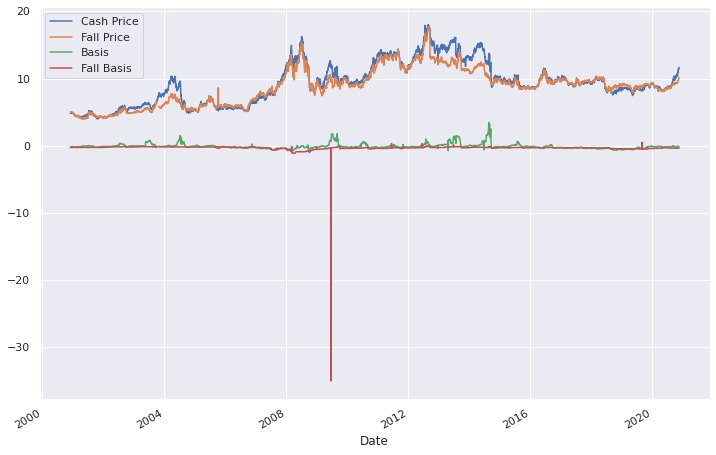

In [30]:
df5[['Cash Price', 'Fall Price', 'Basis', 'Fall Basis']].plot(figsize=(12, 8))

<AxesSubplot:xlabel='Date'>

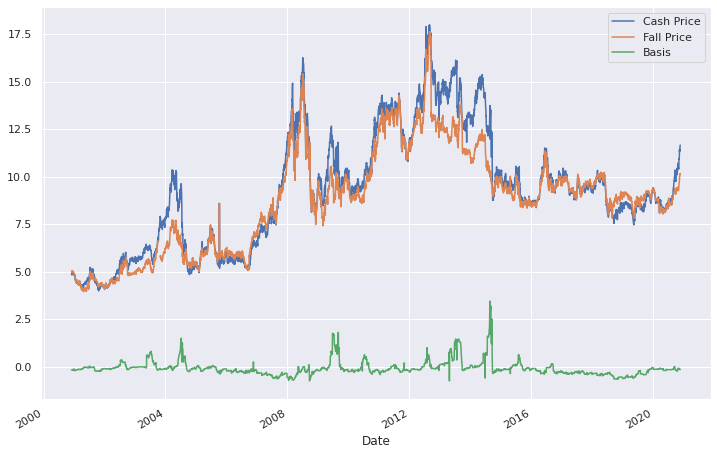

In [31]:
df5[['Cash Price', 'Fall Price', 'Basis']].plot(figsize=(12, 8))

Points to note:
- We will only work with `Cash Price` for the forecasting. There are both increasing and decreasing trends in the cash prices.
- Since soy beans are an agricultural commodity, we see seasonality through the year.

In [32]:
df5.drop(columns=['Basis', 'Fall Price', 'Fall Basis'], inplace=True)

In [33]:
## Following the DataFrame manipulation procedure and further steps
## as recommended in Facebook's Prophet documentation
df5.reset_index(drop=False, inplace=True)
df5.rename(columns={'Date': 'ds', 'Cash Price': 'y'}, inplace=True)

In [34]:
## We split the data into training and test sets (this is the language of machine learning)
## In the language of econometrics, we would call them in-sample and out-of-sample
## Here, we choose data before 2019 as part of the training data set

train_index = df5['ds'].apply(lambda x: x.year) < 2019

In [35]:
## Creating the training set

df5_train = df5.loc[train_index]

In [36]:
## Checking for NaNs

df5_train.isna().sum()

ds    0
y     0
dtype: int64

In [37]:
df5_train.head(), df5_train.tail()

(          ds     y
 0 2000-12-01  4.90
 1 2000-12-04  4.87
 2 2000-12-05  4.83
 3 2000-12-06  4.89
 4 2000-12-07  4.85,
              ds     y
 4523 2018-12-24  8.29
 4524 2018-12-26  8.15
 4525 2018-12-27  8.14
 4526 2018-12-28  8.28
 4527 2018-12-31  8.32)

In [38]:
## Creating the test set

df5_test = df5.loc[~train_index].reset_index(drop=True)

In [39]:
## Checking for NaNs

df5_test.isna().sum()

ds    0
y     0
dtype: int64

In [40]:
df5_test.head(), df5_test.tail()

(          ds     y
 0 2019-01-02  8.44
 1 2019-01-03  8.50
 2 2019-01-04  8.59
 3 2019-01-07  8.61
 4 2019-01-08  8.56,
             ds      y
 473 2020-11-16  11.39
 474 2020-11-17  11.55
 475 2020-11-18  11.61
 476 2020-11-19  11.63
 477 2020-11-20  11.66)

In [41]:
df5.shape, df5_train.shape, df5_test.shape

((5006, 2), (4528, 2), (478, 2))

In [42]:
%%time
## Instantiating the Prophet model
## By default, it is 'additive'.
## On your own time, you can try 'multiplicative' while reviewing the material
model1 = Prophet(seasonality_mode='additive')

CPU times: user 14.1 ms, sys: 628 µs, total: 14.8 ms
Wall time: 29.3 ms


In [43]:
type(model1)

prophet.forecaster.Prophet

In [44]:
%%time
## Additional specification that our data has monthly seasonality
## Other arguments have been set as per the documentation
model1.add_seasonality(name='monthly', period=30.5, fourier_order=5)

## The below method is similar to the scikit-learn library's fit().
## The model is fitted using the training data specified earlier.
model1.fit(df5_train)

10:44:20 - cmdstanpy - INFO - Chain [1] start processing
10:44:23 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 187 ms, sys: 18.5 ms, total: 205 ms
Wall time: 2.43 s


In [45]:
%%time

df5_future = model1.make_future_dataframe(periods=650)
df5_pred = model1.predict(df5_future)

CPU times: user 14.1 s, sys: 33.1 s, total: 47.1 s
Wall time: 3.44 s


In [46]:
df5_future.shape

(5178, 1)

In [47]:
df5_future.head(10)

,ds
0,2000-12-01
1,2000-12-04
2,2000-12-05
3,2000-12-06
4,2000-12-07
5,2000-12-08
6,2000-12-11
7,2000-12-12
8,2000-12-13
9,2000-12-14


In [48]:
df5_future.tail(10)

,ds
5168,2020-10-02
5169,2020-10-03
5170,2020-10-04
5171,2020-10-05
5172,2020-10-06
5173,2020-10-07
5174,2020-10-08
5175,2020-10-09
5176,2020-10-10
5177,2020-10-11


In [49]:
df5_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
5173,2020-10-07,8.929774,3.305550,13.103212,4.257387,13.751103,-0.850999,-0.850999,-0.850999,0.019774,...,-0.061928,-0.061928,-0.061928,-0.808846,-0.808846,-0.808846,0.0,0.0,0.0,8.078775
5174,2020-10-08,8.929452,3.274929,12.665905,4.240041,13.763097,-0.852766,-0.852766,-0.852766,0.016698,...,-0.066896,-0.066896,-0.066896,-0.802568,-0.802568,-0.802568,0.0,0.0,0.0,8.076687
5175,2020-10-09,8.929131,3.332129,12.912953,4.229314,13.775091,-0.856279,-0.856279,-0.856279,0.009862,...,-0.072692,-0.072692,-0.072692,-0.793449,-0.793449,-0.793449,0.0,0.0,0.0,8.072852
5176,2020-10-10,8.928809,3.704335,13.644393,4.224851,13.787086,-0.411756,-0.411756,-0.411756,0.006729,...,0.363218,0.363218,0.363218,-0.781703,-0.781703,-0.781703,0.0,0.0,0.0,8.517054
5177,2020-10-11,8.928488,3.375488,12.996131,4.220387,13.799080,-0.776939,-0.776939,-0.776939,0.008502,...,-0.017867,-0.017867,-0.017867,-0.767574,-0.767574,-0.767574,0.0,0.0,0.0,8.151549


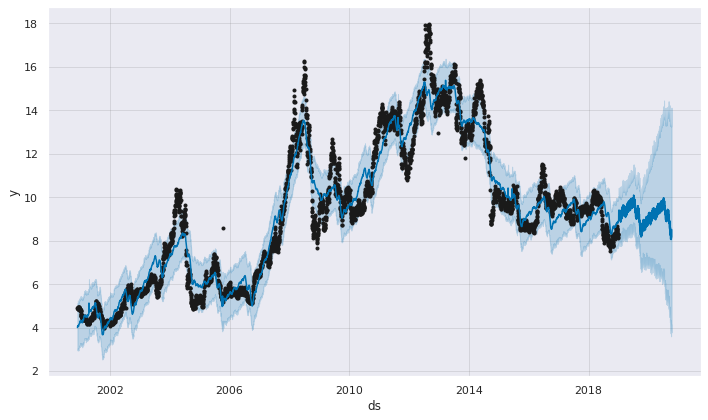

In [55]:
## Plotting the predicted values on test and training data

model1.plot(df5_pred);

Points to note:
- The model's predicted values (blue line) approximately follow the observed soy bean prices (black dots).
- The light blue shadow is the confidence interval for the predicted values. Its width changes over time and quantifies our confidence in the point estimates.
- Visually we see that whenever there's a sharp change in prices, the model fails to predict correctly.

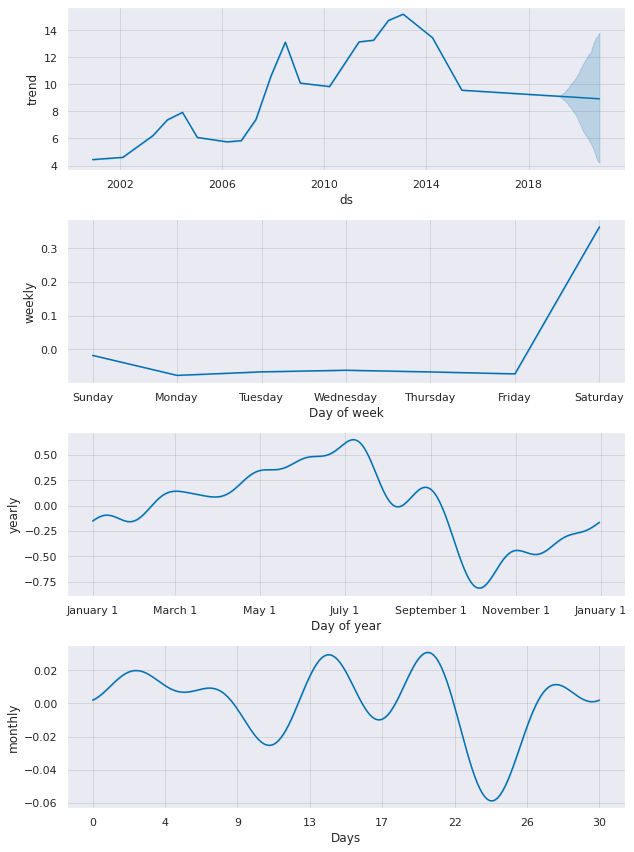

In [50]:
model1.plot_components(df5_pred);

Points to note:
- The overall trend shows an increase in cash prices over the entire time period.
- In the weekly plot, we ignore the prices on weekends (no trading). The prices through the week are quite constant (i.e. no day-of-the-week effect).
- In the yearly plot, there's a wide range of prices (of ~US\$ 1 with a high in July and a low in October) observed across the year. We would expect to see seasonality in an agricultural commodity like soy beans (month-of-the-year effect).
- In the monthly plot, we see some variance but the scale is much smaller than in the previous plot (i.e. no day-of-the-month effect).

In [51]:
%%time
## We create a merged DataFrame to examine the actuals v/s predicted values closely

selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']
df5_pred = df5_pred.loc[:, selected_columns].reset_index(drop=True)

## Using left join, we only select rows that are part of our test data set.
## This would exclude the predictions on holidays and weekends.

df5_test = df5_test.merge(df5_pred, on=['ds'], how='left')

CPU times: user 1.27 ms, sys: 6.15 ms, total: 7.42 ms
Wall time: 9.27 ms


In [52]:
df5_test['ds'] = pd.to_datetime(df5_test['ds'])

In [53]:
df5_test.set_index('ds', inplace=True)

CPU times: user 118 ms, sys: 14.7 ms, total: 132 ms
Wall time: 109 ms


[Text(0.5, 1.0, 'Soy bean price - actual vs. predicted'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Price per bushel (US$)')]

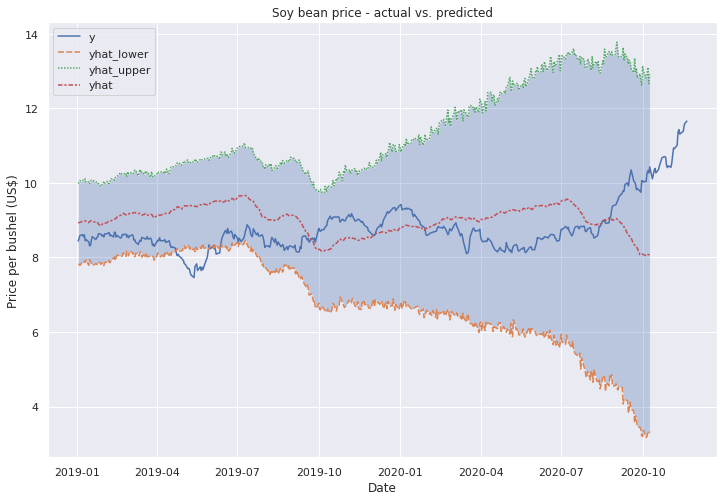

In [54]:
%%time

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.lineplot(data=df5_test[['y', 'yhat_lower', 
                                 'yhat_upper', 'yhat']])
ax.fill_between(df5_test.index, df5_test.yhat_lower, 
                df5_test.yhat_upper, alpha=0.3)
ax.set(title='Soy bean price - actual vs. predicted', 
       xlabel='Date', ylabel='Price per bushel (US$)')

Points to note:
- The interval estimate of the soy bean price prediction appears to have been accurate for the whole period (except a month in May 2019).
- The confidence interval in the last six months is wider than in the initial period.

### Checking for stationarity

There are three ways of checking for stationarity in a time series.
1. Visual inspection
2. Statistical tests
3. ACF/PACF plots

We prefer working with stationary time series processes because it makes modeling, analysis and forecasting more feasible.

For this section, we work with the last 25 years of daily gold prices in India. The prices shown are denominated in INR per ounce.

> *Gold is a liquid asset, ranking at levels comparable to many global stock markets as well as currency spreads. Its liquidity is often sourced during periods of stress in the markets, one of its appealing qualities.* - [Source](https://www.gold.org/goldhub/data/trading-volumes)


In [55]:
start6 = '1995-01-01'
end6 = '2021-09-29'
ticker6 = "WGC/GOLD_DAILY_INR"

In [56]:
df = nasdaqdatalink.get(dataset=ticker6, start_date=start6, end_date=end6)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker6} data")

Downloaded 6575 rows and 1 columns of WGC/GOLD_DAILY_INR data


In [57]:
#############################################################################
################# PLEASE USE BELOW STATEMENTS IF NEEDED #####################
#############################################################################

## If you have don't have quandl, you can read the csv file as shown.

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df.to_csv("gold_prices_inr.csv")
# df4 = pd.read_csv("gold_prices_inr.csv", index_col=0, parse_dates=True)
# df1 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

In [58]:
df.head()

,Value
Date,
1995-01-02,12022.09
1995-01-03,11948.83
1995-01-04,11781.62
1995-01-05,11771.27
1995-01-06,11769.08


In [59]:
df.tail()

,Value
Date,
2020-03-09,123911.33
2020-03-10,122666.66
2020-03-11,121778.01
2020-03-12,116573.42
2020-03-13,115510.47


In [60]:
df6 = df.copy()

In [61]:
df6.rename(columns={"Value": "price"}, inplace=True)

In [62]:
df6.tail()

,price
Date,
2020-03-09,123911.33
2020-03-10,122666.66
2020-03-11,121778.01
2020-03-12,116573.42
2020-03-13,115510.47


In [63]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as sms
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

In [64]:
def check_stationarity(y, wl1=21, wl2=252, lags=40, figsize=(18, 12)):
    """ Checks the stationarity of a pandas Series (default is daily prices or returns),
        using plots, correlograms and the ADF test
    """
    ## Calculating rolling statistics
    
    rolling_wl1_mean = y.rolling(window=wl1).mean()
    rolling_wl2_mean = y.rolling(window=wl2).mean()
    rolling_wl1_vol = y.rolling(window=wl1).std()
    rolling_wl2_vol = y.rolling(window=wl2).std()
    
    ## Plotting the price, rolling statistics and correlograms
    
    fig = plt.figure(figsize=(18, 14))
    sns.set(font_scale=1)
    layout = (2, 2)
    y_ax = plt.subplot2grid(layout, (0, 0))
    vol_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
        
    y.plot(ax=y_ax)
    rolling_wl1_mean.plot(ax=y_ax)
    rolling_wl2_mean.plot(ax=y_ax)
    
    rolling_wl1_vol.plot(ax=vol_ax)
    rolling_wl2_vol.plot(ax=vol_ax)
    y_ax.set_title('Rolling means over time')
    y_ax.legend(['observed', f'{wl1}-period MA of observed', f'{wl2}-period MA of observed'], loc='best')
    #y_ax.set_ylabel("Gold prices(in INR)/oz.")
    
    vol_ax.set_title('Rolling volatility over time')
    vol_ax.legend([f'{wl1}-period MA of volatility', f'{wl2}-period MA of volatility'], loc='best')
    
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
    
    ## Running the Augmented Dickey-Fuller test
    print('--------------------------------------------------------------')
    print('--------- The augmented Dickey-Fuller test results -----------')
    print('--------------------------------------------------------------')
    adftest = adfuller(y, autolag='AIC')
    results = pd.Series(adftest[0:4], index=['Test Statistic','p-value','# of Lags','# of Observations'])
    for key,value in adftest[4].items():
        results[f'Critical Value ({key})'] = '{0:.3f}'.format(value)
    print(results)
    print('--------------------------------------------------------------')

In [65]:
check_stationarity?

Signature: check_stationarity(y, wl1=21, wl2=252, lags=40, figsize=(18, 12))
Docstring:
Checks the stationarity of a pandas Series (default is daily prices or returns),
using plots, correlograms and the ADF test
File:      /tmp/ipykernel_54816/2742863286.py
Type:      function


--------------------------------------------------------------
--------- The augmented Dickey-Fuller test results -----------
--------------------------------------------------------------
Test Statistic          1.054921
p-value                 0.994813
# of Lags                   32.0
# of Observations         6542.0
Critical Value (1%)       -3.431
Critical Value (5%)       -2.862
Critical Value (10%)      -2.567
dtype: object
--------------------------------------------------------------


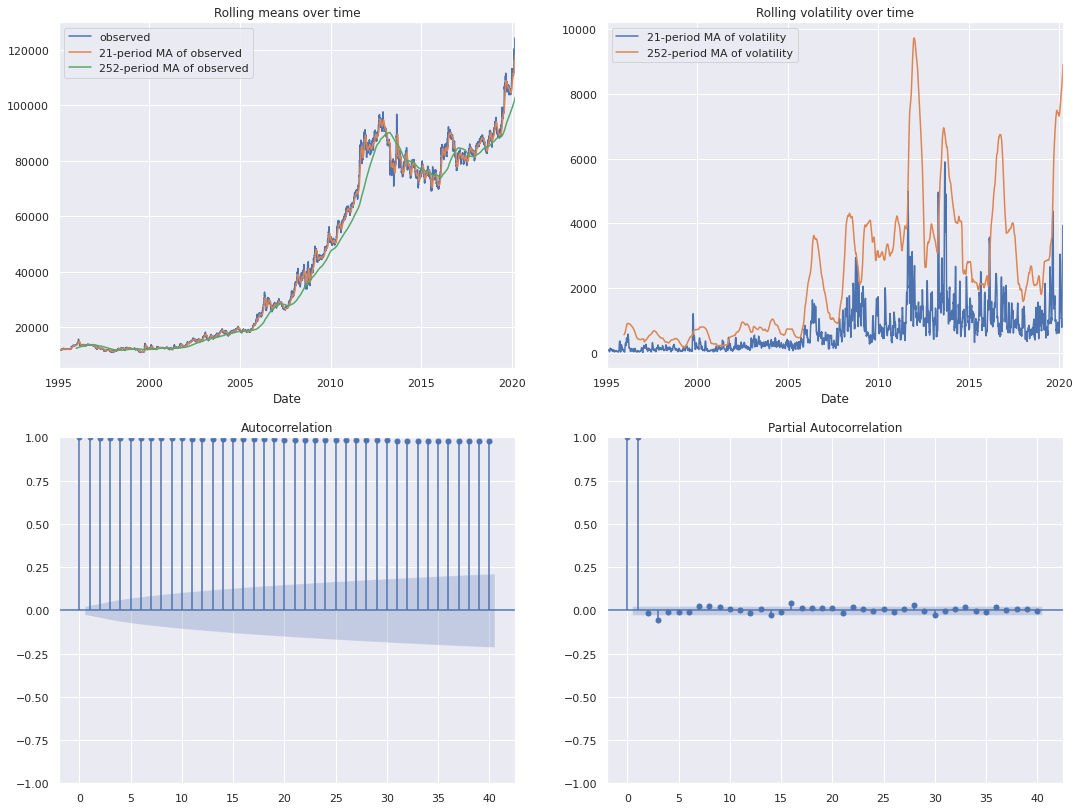

In [66]:
check_stationarity(df6['price'])

Points to note:
- In the ADF test, if the test statistic is greater than the critical value, we conclude that the series is non-stationary. We can draw the same conclusion by examining the p-value. A p-value greater than our significance level (conventionally 5%) means we cannot reject our null hypothesis (The series is not stationary). 
- For the gold prices, we have a p-value of nearly 1 (and equivalently the test statistic is greater than the critical values at all 3 significance levels), so we conclude that the price series is not stationary.
- The rolling means and volatility plots are time-varying. So we also conclude visually that gold prices in India are non-stationary.
- From the ACF, there are significant autocorrelations above the 95% confidence interval at all lags. From the PACF, we have significance in autocorrelations at lags 1, 2, 3, 6, and 8.

In [73]:
df6['log_returns'] = np.log(df6['price'] / df6['price'].shift(1))
df6.dropna(axis='rows', how='any', inplace=True)

--------------------------------------------------------------
--------- The augmented Dickey-Fuller test results -----------
--------------------------------------------------------------
Test Statistic         -17.500127
p-value                       0.0
# of Lags                    26.0
# of Observations          6547.0
Critical Value (1%)        -3.431
Critical Value (5%)        -2.862
Critical Value (10%)       -2.567
dtype: object
--------------------------------------------------------------


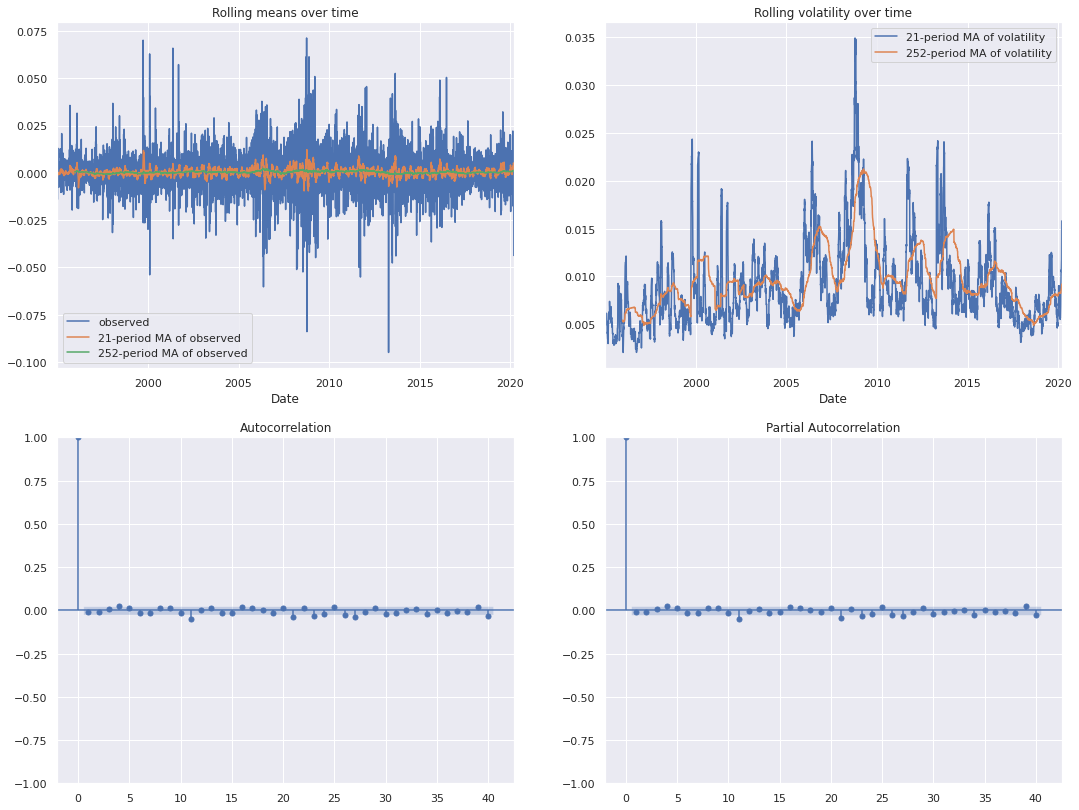

In [74]:
check_stationarity(df6['log_returns'])

Points to note:
- As per the ADF test results, the returns of gold are stationary since the p-value is almost 0 and the test statistic is less than all the critical values.
- The returns and rolling means of the returns are all centred around 0. As the time scale increases, the means become more and more constant. At shorter time scales, the noise tends to obscure the signal.
- The volatily is time-varying at both the faster and slower rolling levels.
- There are little spikes in the ACF plot at lags 3, 11, and 21.

#### Method III : Modeling time series using ARIMA models

The **ARIMA (AutoRegressive Integrated Moving Average)** class of models is a popular statistical technique in time series forecasting. It exploits different standard temporal structures seen in time series processes.

> *Exponential smoothing and ARIMA models are the two most widely used approaches to time series forecasting, and provide complementary approaches to the problem. While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data.* - [Source](#hyndman)

##### ***Crash course on ARIMA***
We will now take a brief look at its key features by taking apart the acronym.

1. **Auto Regressive (AR)**:

- Regression of a time series process onto itself (its past versions)
- A time series process is $AR$ if its present value depends on a linear combination of past observations.
- In financial time series, an $AR$ model attempts to explain the mean reversion and trending behaviours that we observe in asset prices.

2. **Integrated (I)**:

For a time series process ${X_t}$ recorded at regular intervals, the difference operation is defined as $$\nabla X_t = X_t - X_{t-1}$$

The difference operator (denoted by $\nabla$) can be applied repeatedly. For example, 
$$\nabla^2 X_t = \nabla X_t - \nabla X_{t-1}$$

- A time series process is integrated of order $d$ (denoted by $I(d)$), if differencing the observations $d$ times, makes the process stationary.

3. **Moving Average (MA)**:

-  A time series process is $MA$ if its present value can be written as a linear combination of past error terms.
- $MA$ models try to capture the idiosyncratic shocks observed in financial markets. We can think of events like terrorist attacks, earnings surprises, sudden political changes, etc. as the random shocks affecting the asset price movements.

When we use the ARIMA class to model a time series process, each of the above components are specified in the model as parameters (with the notations $p$, $d$, and $q$ respectively). 

That is, the classification $ARIMA(p, d, q)$ process can be thought of as $$AR(p)I(d)MA(q)$$ 
Here,

1. $p$: The number of past observations (we usually call them *lagged terms*) of the process included in the model.
2. $d$: The number of times we difference the original process to make it stationary.
3. $q$: The number of past error terms (we usually call them *lagged error terms* or *lagged residuals*) of the process included in the model.

When we model our time series process with the ARIMA class, we implicitly assume that the underlying data generating process (and by extension the observations we record) is an ARIMA process. 

We should validate our assumptions (especially the implicit ones which slip under the radar) and recognize the limitations of our models. A well-known deficiency of ARIMA applications on financial time series is its failure to capture the phenomenon of volatility clustering. However, despite their inaccurate point estimates, they give rise to informative confidence intervals.

 **All of the below models would have good explanatory and predictive power only if the process is stationary.**

$$AR(1) : x_t = \phi x_{t-1} + \epsilon_t$$
$$MA(1) : x_t = \epsilon_t + \theta \epsilon_{t-1}$$

$$AR(p) : x_t = \phi_1 x_{t-1} + \phi_2 x_{t-2} + \dots + \phi_p x_{t-p} + \epsilon_t$$
$$MA(q) : x_t = \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q}$$

$$ARMA(p, q) : x_t = \phi_1 x_{t-1} + \phi_2 x_{t-2} + \dots + \phi_p x_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q}$$

We now fit an ARIMA model to the weekly stock prices (from mid-2010 to mid-2019) of `Netflix` and learn to evaluate it.

In [80]:
start8 = datetime.date(2010, 6, 30)
end8 = datetime.date(2019, 7, 1)
ticker8 = "NFLX"

In [81]:
df = yf.download(ticker8, start=start8, end=end8, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker8} data")

Downloaded 2266 rows and 6 columns of NFLX data


In [82]:
#############################################################################
################# PLEASE USE BELOW STATEMENTS IF NEEDED #####################
#############################################################################

## If you have don't have quandl, you can read the csv file as shown.

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df.to_csv(f"{ticker8}.csv")
# df4 = pd.read_csv("NFLX.csv", index_col=0, parse_dates=True)
# df1 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

In [83]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,16.488571,16.547144,16.010000,16.082857,16.082857,20429500
2010-06-30,15.712857,16.184286,15.427143,15.521429,15.521429,26104400
2010-07-01,15.542857,15.780000,14.752857,15.665714,15.665714,22759800
2010-07-02,15.808571,15.920000,15.185714,15.297143,15.297143,11218200
2010-07-06,15.628571,15.915714,15.184286,15.324286,15.324286,15773800


In [84]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-06-24,370.269989,375.000000,370.200012,371.040009,371.040009,4830200
2019-06-25,370.750000,371.000000,358.290009,360.299988,360.299988,5750400
2019-06-26,361.600006,366.790009,361.600006,362.200012,362.200012,3669700
2019-06-27,363.200012,370.850006,363.200012,370.019989,370.019989,4138600
2019-06-28,370.260010,371.540009,364.869995,367.320007,367.320007,4592700


In [85]:
df8 = df.copy()

In [86]:
## Resampling to obtain weekly stock prices with the following rules
## 'Open': first opening price of the month
## 'High': max price of the month
## 'Low': min price of the month
## 'Close' and 'Adj Close': last closing price of the month

df8 = df8.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 
                             'Close':'last', 'Adj Close':'last'})

In [87]:
df8.drop(columns=["Open", "High", "Low", "Close"], inplace=True)
df8.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df8.tail())

             adj_close
Date                  
2019-06-02  343.279999
2019-06-09  360.869995
2019-06-16  339.730011
2019-06-23  369.209991
2019-06-30  367.320007


In [88]:
## Checking for null values

df8[df8['adj_close'].isnull()]

,adj_close
Date,


In [89]:
start8_str = (start8 + pd.Timedelta("5 days")).strftime("%B %Y")
end8_str = (end8 - pd.Timedelta("5 days")).strftime("%B %Y")

<AxesSubplot:title={'center':'NFLX weekly adjusted close prices (July 2010 - June 2019)'}, xlabel='Date'>

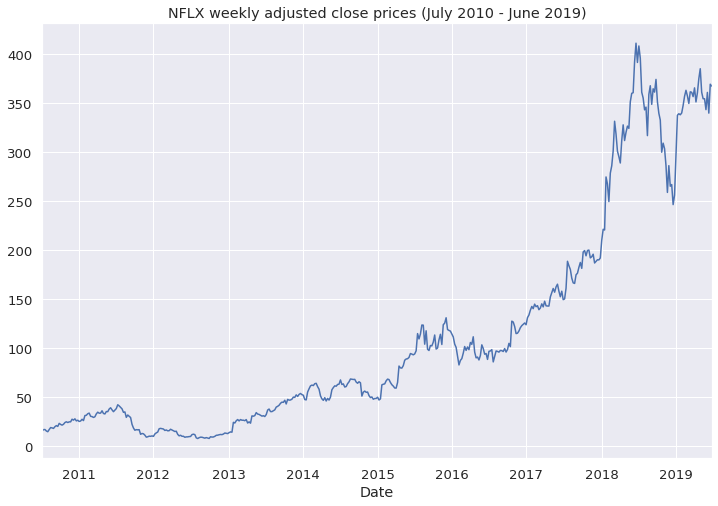

In [90]:
sns.set(font_scale=1.2)
df8['adj_close'].plot(figsize=(12, 8), title=f"{ticker8} weekly adjusted close prices ({start8_str} - {end8_str})")

In [91]:
check_stationarity?

Signature: check_stationarity(y, wl1=21, wl2=252, lags=40, figsize=(18, 12))
Docstring:
Checks the stationarity of a pandas Series (default is daily prices or returns),
using plots, correlograms and the ADF test
File:      /tmp/ipykernel_54816/2742863286.py
Type:      function


--------------------------------------------------------------
--------- The augmented Dickey-Fuller test results -----------
--------------------------------------------------------------
Test Statistic          0.507267
p-value                 0.985092
# of Lags                   16.0
# of Observations          453.0
Critical Value (1%)       -3.445
Critical Value (5%)       -2.868
Critical Value (10%)      -2.570
dtype: object
--------------------------------------------------------------
CPU times: user 275 ms, sys: 298 ms, total: 573 ms
Wall time: 168 ms


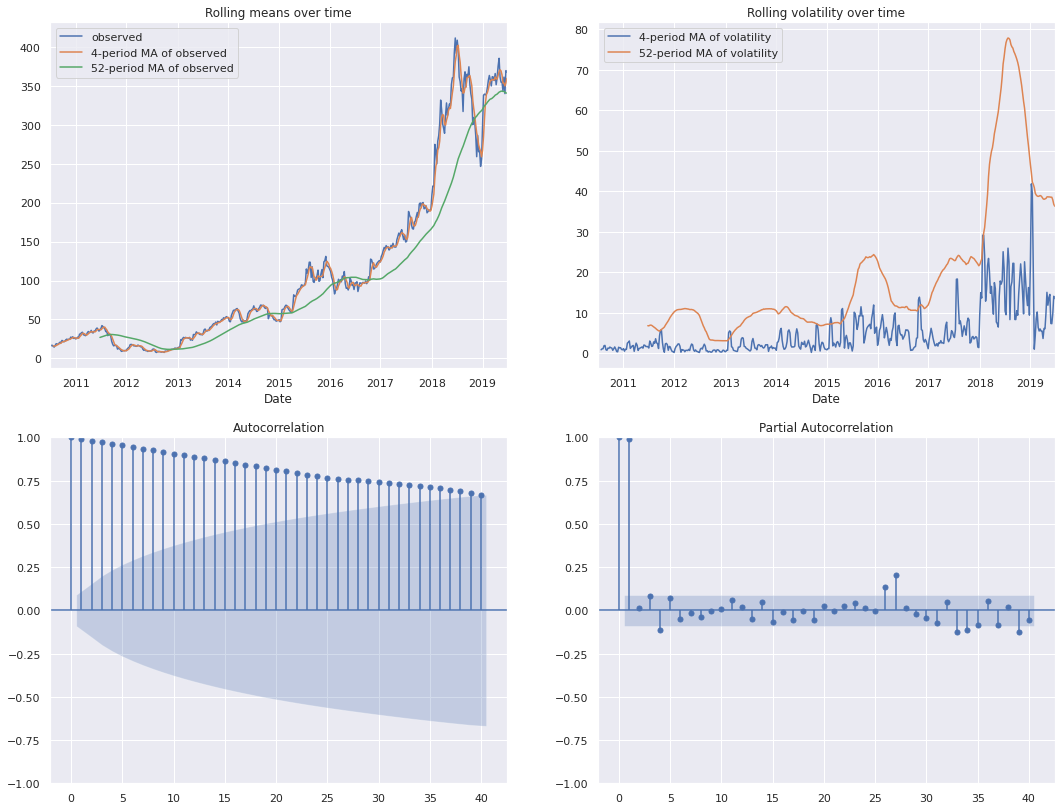

In [92]:
%%time

check_stationarity(df8['adj_close'], wl1=4, wl2=52)

Points to note:
- The p-value is nearly 1 (and equivalently the test statistic is greater than the critical values at all 3 significance levels). So the ADF test result is that the price series is non-stationary.
- The rolling means and volatility plots are time-varying. So we arrive at the same conclusion by examining the plots.
- From the ACF, there are significant autocorrelations above the 95% confidence interval at all lags. From the PACF, we have spikes at lags 1, 8, 9, 13, 18, 23 and 38.

In [93]:
df8['log_returns'] = np.log(df8['adj_close'] / df8['adj_close'].shift(1))
df8.dropna(axis='rows', how='any', inplace=True)

--------------------------------------------------------------
--------- The augmented Dickey-Fuller test results -----------
--------------------------------------------------------------
Test Statistic         -21.695175
p-value                       0.0
# of Lags                     0.0
# of Observations           468.0
Critical Value (1%)        -3.444
Critical Value (5%)        -2.868
Critical Value (10%)       -2.570
dtype: object
--------------------------------------------------------------
CPU times: user 281 ms, sys: 263 ms, total: 544 ms
Wall time: 171 ms


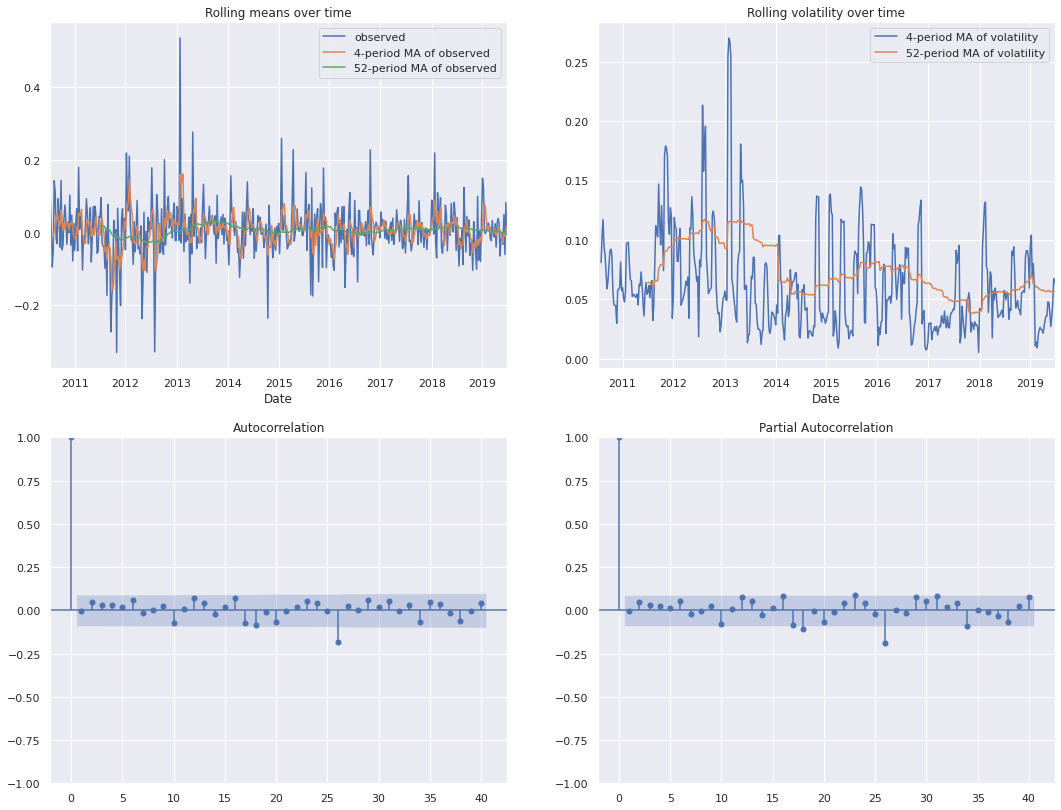

In [94]:
%%time

check_stationarity(df8['log_returns'], wl1=4, wl2=52)

Points to note:
- As per the ADF test results, the `Netflix` returns are stationary since the p-value is almost 0 and the test statistic is less than all the critical values.
- The returns and rolling means of the returns are all centred around 0. As the time scale increases, the means become more and more constant. At shorter time scales, the noise tends to obscure the signal.
- The volatily is time-varying at both the faster and slower rolling levels.
- We can see bristles near or beyond the blue shadow at lags 17 and 26 in the ACF plot and lags 12, 16, 17, 18 and 26 in the PACF plot.
- **Returns are log price differences. So we can also infer from the above two checks, that the price series is integrated with order $1.$**

In [95]:
%%time
##########################################################
################ ARIMA model fitting #####################
##########################################################
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

## Creating the ARIMA model class
## We select the order arbitrarily (p and q)
## We inferred d from the results of `check_stationarity`

## Defining the model by providing the training set and providing the parameters p, d, q
arima_model = ARIMA(df8['adj_close'], order=(3, 1, 2))

## Fitting the model, disp=0 is to switch off verbose display
arima_fit1 = arima_model.fit()

## Printing a summary of the model
arima_fit1.summary()


CPU times: user 507 ms, sys: 1.06 s, total: 1.57 s
Wall time: 260 ms


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  469
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1671.220
Date:                Mon, 11 Jul 2022   AIC                           3354.439
Time:                        13:53:21   BIC                           3379.330
Sample:                    07-11-2010   HQIC                          3364.234
                         - 06-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4100      0.089     -4.605      0.000      -0.584      -0.235
ar.L2         -0.7061      0.093     -7.575      0.000      -0.889      -0.523
ar.L3          0.0750      0.035      2.125      0.034       0.006       0.144
ma.L1          0.3611      0.080      4.501      0.000       0.204       0.518
ma.L2          0.7301      0.083      8.832      0.000       0.568       0.892
sigma2        73.9779      2.192     33.751      0.000      69.682      78.274
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1241.96
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              49.30   Skew:                             0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predicted model:

$\hat{y_t} = y_{t-1} - 0.41{y_{t-1}} - 0.71{y_{t-2}} + 0.075{y_{t-3}} + 0.3611{\epsilon_{t-1}} + 0.73{\epsilon_{t-2}}$



Points to note:
- We chose an $ARIMA(3, 1, 2)$ model to fit the price series of `Netflix`. Equivalently, we could have fit an $ARIMA(3, 0, 2)$ to the returns instead. 
- The `summary()` method provides the results of the model fitting exercise on the **in-sample data set** (a.k.a. the training data).
- The most important part is the table at the centre which has the coefficient values, their 95% confidence intervals and their corresponding p-values.
- However, we also need to run model diagnostics by examining the residual errors closely. This will tell us if our model was a good fit to the underlying data.

In [96]:
def arima_diagnostics(resids_, figsize=(15, 9), n_lags=40):
    '''
    Diagnoses the fit of an ARIMA model by examining its residuals.
    Returns a chart with with multiple plots
    '''
    # Creating placeholder subplots
    M = 2
    N = 2
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(M, N, figsize=figsize)

    r = resids_
    resids_ = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids_[~(np.isnan(resids_))]
    
    # Plotting residuals over time
    sns.lineplot(x=np.arange(len(resids_)), 
                 y=resids_, ax=ax1)
    ax1.set_title('Standardized residuals')

    # Plotting the distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    sns.distplot(resids_nonmissing, hist=True, kde=True, 
                 norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, color='green', linewidth=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
        
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ## 's' is for standardized line to compare the plot with a normal distribution
    ax3.set_title('Q-Q plot')

    # ACF plot
    sm.graphics.tsa.plot_acf(resids_, lags=n_lags, ax=ax4, alpha=0.05)
    ax4.set_title('ACF plot')

    return fig

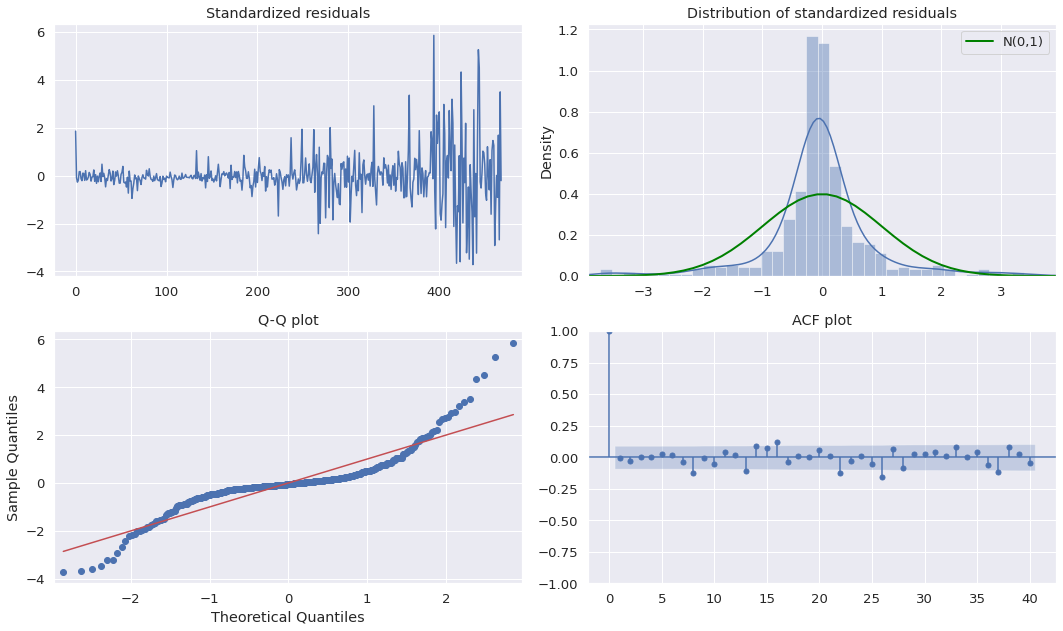

CPU times: user 763 ms, sys: 266 ms, total: 1.03 s
Wall time: 695 ms


In [97]:
%%time
sns.set(font_scale=1.2)
arima_diagnostics(arima_fit1.resid)
plt.tight_layout()
plt.show();

Points to note:
    
- `Standardized residuals`: The mean of the residuals is approximately zero. However, it's variance is much higher in the second half of the series.
- `Distribution of standardized residuals` and `Q-Q plot`: Both plots indicate fatter tails compared to a normal distribution.
- `ACF plot`: There seems to be serial correlations at lags 8, 13, 14, 22 and a few more. 
- **If the fit is good, we should see residuals similar to Gaussian white noise. It's not so here.**
- So we can infer that the model is not a very good fit.

##### Statistical tests we additionally run

1. *To check for autocorrelations in residuals: [`The Ljung-Box test`](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test)*

The null hypothesis is that the serial correlations of the time series are zero. We use it in addition to visual interpretation of ACF/PACF plots.

2. *To check for normality in residuals: [`The Jarque-Bera test`](https://en.wikipedia.org/wiki/Jarque-Bera_test)*

The null hypothesis is that the time series is normally distributed. We use it in addition to visual interpretation of plots like the residual distribution and the Q-Q plots.



[Text(0.5, 1.0, 'Ljung-Box test results (after modeling NFLX stock prices)'),
 Text(0.5, 0, 'Lags'),
 Text(0, 0.5, 'p-value')]

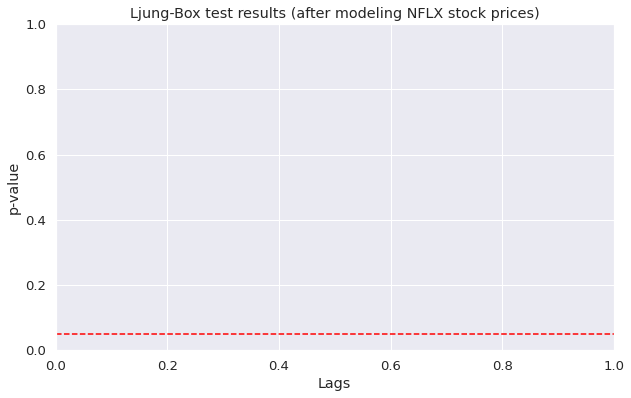

In [98]:
## Running the Ljung-Box test and plotting the results

ljung_box_results = sm.stats.acorr_ljungbox(arima_fit1.resid)
fig, ax = plt.subplots(1, figsize=(10, 6))
#sns.scatterplot(x=range(len(ljung_box_results[1])), y=ljung_box_results[1], ax=ax)
ax.axhline(0.05, ls='--', color='red')
ax.set(title=f"Ljung-Box test results (after modeling {ticker8} stock prices)", xlabel='Lags', ylabel='p-value')

Points to note:
    
- There are no significant serial correlations until lag 12.
- However, many of the correlations from lag 13 are below the red line.
- So our model is not a good fit.

In [99]:
## Running the Jarque-Bera test and interpreting its results

from statsmodels.stats.stattools import jarque_bera

jb_test_stat, pvalue, _, _ = jarque_bera(arima_fit1.resid)
print(f"Jarque-Bera statistic: {jb_test_stat:.2f} with p-value: {pvalue:.2f}")

if pvalue < 0.05:
    print("Our residuals are likely not normally distributed.")
else:
    print("Our residuals are likely normally distributed.")


Jarque-Bera statistic: 1205.73 with p-value: 0.00
Our residuals are likely not normally distributed.


In [ ]:
## ***********************************************************
## ******* Manually checking for best ARIMA ******************
## ***********************************************************

############## Please try on your own time ##################
## Make necessary modifications (if needed) to the below code


# %%time

# best_aic = np.inf
# best_order = None
# best_mdl = None

# pq_rng = range(5)
# d_rng = range(2)
# for i in pq_rng:
#     for d in d_rng:
#         for j in pq_rng:
#             try:
#                 tmp_mdl = ARIMA(df8['adj_close'], order=(i, d, j)).fit(method='mle', trend='nc')
#                 tmp_aic = tmp_mdl.aic
#                 if tmp_aic < best_aic:
#                     best_aic = tmp_aic
#                     best_order = (i, d, j)
#                     best_mdl = tmp_mdl
#             except:
#                 continue
            
# print("aic : ",best_aic, "| order : ",best_order)

##### Automatically finding the best ARIMA fit (using the [`pmdarima`](https://alkaline-ml.com/pmdarima/develop/about.html) library)

In [100]:
%%time

import pmdarima as pm

## Fitting the model (This is the default setting)
arima_fit2 = pm.auto_arima(df8['adj_close'], error_action='ignore', 
                           suppress_warnings=True, seasonal=False)

CPU times: user 4.32 s, sys: 4.76 s, total: 9.07 s
Wall time: 2.79 s


In [101]:
## Printing a summary of the model
arima_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  469
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1669.602
Date:                Mon, 11 Jul 2022   AIC                           3351.204
Time:                        15:03:09   BIC                           3376.095
Sample:                             0   HQIC                          3360.999
                                - 469                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7575      1.010      1.740      0.082      -0.222       3.737
ar.L1         -0.4484      0.050     -8.969      0.000      -0.546      -0.350
ar.L2         -0.8823      0.043    -20.423      0.000      -0.967      -0.798
ma.L1          0.3709      0.052      7.154      0.000       0.269       0.472
ma.L2          0.8921      0.041     21.775      0.000       0.812       0.972
sigma2        73.4622      2.311     31.793      0.000      68.933      77.991
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):              1310.00
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):              43.56   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [102]:
%%time

## Fitting the model(With more tuning of the parameters)
arima_fit3 = pm.auto_arima(df8['adj_close'], error_action='ignore', 
                           suppress_warnings=True, stepwise=False, 
                           approximation=False, seasonal=False)

arima_fit3.summary()

CPU times: user 5.65 s, sys: 7.15 s, total: 12.8 s
Wall time: 3.36 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  469
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1669.602
Date:                Mon, 11 Jul 2022   AIC                           3351.204
Time:                        15:03:13   BIC                           3376.095
Sample:                             0   HQIC                          3360.999
                                - 469                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7575      1.010      1.740      0.082      -0.222       3.737
ar.L1         -0.4484      0.050     -8.969      0.000      -0.546      -0.350
ar.L2         -0.8823      0.043    -20.423      0.000      -0.967      -0.798
ma.L1          0.3709      0.052      7.154      0.000       0.269       0.472
ma.L2          0.8921      0.041     21.775      0.000       0.812       0.972
sigma2        73.4622      2.311     31.793      0.000      68.933      77.991
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):              1310.00
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):              43.56   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Points to note:

- The most suitable model is $ARIMA(2, 1, 2)$
- Our guiding principle when we build models is [Occam's Razor](http://pespmc1.vub.ac.be/OCCAMRAZ.html) i.e. we want a model with the fewest parameters that can explain our time series process. 
- We therefore use information criterion ([Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion)).
- When choosing from multiple competing models, we choose the one which has the smallest AIC.
- The idea is to find the right balance between underfitting and overfitting. AIC helps us find that.


#### Forecasting using the ARIMA class

We will forecast using both, $ARIMA(3, 1, 2)$ and $ARIMA(2, 1, 2)$. 

In [103]:
start9 = datetime.date(2019, 6, 30)
end9 = datetime.date(2020, 7, 7)
ticker9 = ticker8

In [104]:
df = yf.download(ticker9, start=start9, end=end9, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker9} data")

Downloaded 256 rows and 6 columns of NFLX data


In [105]:
#############################################################################
################# PLEASE USE BELOW STATEMENTS IF NEEDED #####################
#############################################################################

## If you have don't have quandl, you can read the csv file as shown.

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df.to_csv(f"{ticker8}2.csv")
# df4 = pd.read_csv("NFLX.csv", index_col=0, parse_dates=True)
# df1 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

In [106]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-07-01,373.500000,376.660004,372.000000,374.600006,374.600006,4992600
2019-07-02,374.890015,376.000000,370.309998,375.429993,375.429993,3625000
2019-07-03,376.690002,381.989990,375.839996,381.720001,381.720001,3799000
2019-07-05,378.290009,381.399994,375.559998,380.549988,380.549988,3732200
2019-07-08,378.190002,378.250000,375.359985,376.160004,376.160004,3113400


In [107]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-29,445.230011,447.670013,432.140015,447.239990,447.239990,4844000
2020-06-30,450.019989,457.589996,447.000000,455.040009,455.040009,4198500
2020-07-01,454.000000,488.230011,454.000000,485.640015,485.640015,9705900
2020-07-02,485.640015,492.279999,475.529999,476.890015,476.890015,6351500
2020-07-06,480.769989,499.500000,479.799988,493.809998,493.809998,7839000


In [108]:
df9 = df.copy()

In [109]:
## Resampling to obtain weekly stock prices with the following rules
## 'Open': first opening price of the month
## 'High': max price of the month
## 'Low': min price of the month
## 'Close' and 'Adj Close': last closing price of the month

df9 = df9.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 
                             'Close':'last', 'Adj Close':'last'})

In [110]:
df9.drop(columns=["Open", "High", "Low", "Close"], inplace=True)
df9.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df9.tail())

             adj_close
Date                  
2020-06-14  418.070007
2020-06-21  453.720001
2020-06-28  443.399994
2020-07-05  476.890015
2020-07-12  493.809998


In [111]:
## Checking for null values

df9[df9['adj_close'].isnull()]

,adj_close
Date,


In [112]:
%%time

## Forecasting using the first model, ARIMA(3, 1, 2)

n_fcast1 = len(df9)
arima_fcast1 = arima_fit1.forecast(n_fcast1)

CPU times: user 17.3 ms, sys: 1.7 ms, total: 19 ms
Wall time: 18.5 ms


In [113]:
type(arima_fcast1)

pandas.core.series.Series

In [114]:
arima_fcast1[1]

370.4882127136066

In [115]:
%%time

arima_fcast1 = [pd.DataFrame(arima_fcast1[0], columns=['forecast']), 
                pd.DataFrame(arima_fcast1[2], columns=['lower_95', 
                                                       'upper_95'])]

arima_fcast1 = pd.concat(arima_fcast1, axis=1).set_index(df9.index)

ValueError: DataFrame constructor not properly called!

In [116]:
%%time
## Forecasting using the second model, ARIMA(2, 1, 2)

arima_fcast3 = arima_fit3.predict(n_periods=n_fcast1, 
                                  return_conf_int=True, alpha=0.05)

CPU times: user 5.13 ms, sys: 1.5 ms, total: 6.63 ms
Wall time: 5.62 ms


In [117]:
%%time

arima_fcast3 = [pd.DataFrame(arima_fcast3[0], columns=['prediction']), 
                pd.DataFrame(arima_fcast3[1], columns=['lower_95', 
                                                       'upper_95'])]

arima_fcast3 = pd.concat(arima_fcast3, axis=1).set_index(df9.index)

CPU times: user 1.11 ms, sys: 803 µs, total: 1.91 ms
Wall time: 1.62 ms


AttributeError: 'Series' object has no attribute 'forecast'

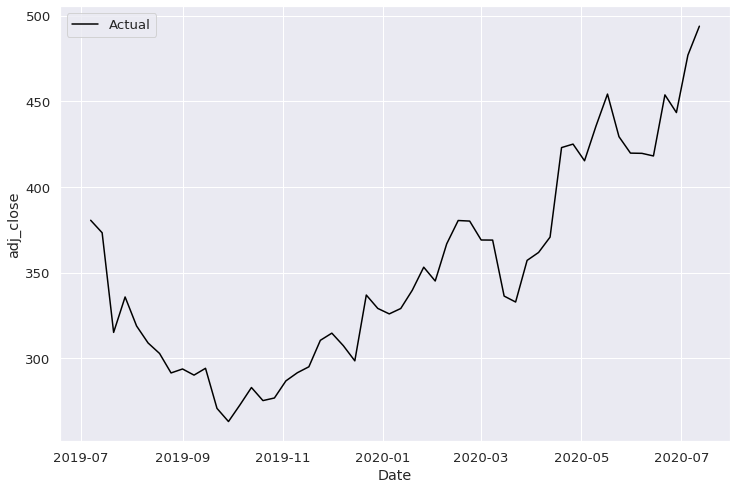

In [118]:
%%time

## Plotting the results for both models

fig, ax = plt.subplots(1, figsize=(12, 8))

ax = sns.lineplot(data=df9['adj_close'], color='black', label='Actual')

ax.plot(arima_fcast1.forecast, color='green', label='ARIMA(3, 1, 2)')

ax.fill_between(arima_fcast1.index, arima_fcast1.lower_95, 
                arima_fcast1.upper_95, alpha=0.3, 
                facecolor='green')

ax.plot(arima_fcast3.prediction, color='red', label='ARIMA(2, 1, 2)')

ax.fill_between(arima_fcast3.index, arima_fcast3.lower_95, 
                arima_fcast3.upper_95, alpha=0.2, 
                facecolor='red')

ax.set(title=f"{ticker8} stock price - actual vs. predicted", xlabel='Date',
       ylabel='Adjusted close price (US$)')
ax.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/ch3_im25.png')
plt.show()


## A brief look at modeling volatility using the ARCH/GARCH family of models

The ARIMA class of models is widely used in asset price forecasting. However, as we have seen, time-varying volatility and volatility clustering (heteroskedasticity) are recurrent themes in finance. The ARMA/ARIMA models do not account for it. Fortunately, we have the ARCH/GARCH method which allows us to model for the time-dependent change in the volatility of a time-series.

The $ARIMA + GARCH$ combination is used to improve forecasts. In practice, we jointly estimate the mean returns and the volatility associated with the returns.

We model conditional variance in Python with the `arch` library.

## Autoregressive Conditionally Heteroskedastic Models (ARCH)

If we observe the name of the model, we can make a pretty good guess what it does. It estimates the conditional variance($\sigma_t$ in the below setup) over time based on the past values of the variance (hence the name autoregressive). We now consider the $ARCH(1)$ model below which can be easily generalized to $ARCH(q)$.

$$r_t = \mu + \epsilon_t$$ Above, we express returns as a (multiplicative) combination of deterministic and stochastic components.
$$\epsilon_t = \sigma_t w_t$$ Carrying on from the previous step, we express the stochastic component as a combination of Gaussian white noise $w_t$ and the conditional standard deviation $\sigma_t$.
<div class="alert alert-success">$$\sigma_{t}^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2$$</div> 

***This is the ARCH model where $\alpha_0$ and $\alpha_1$ are its parameters.***

It is useful to think of $ARCH(q)$ as the application of $AR(p)$ to the variance of a time series process.

In [119]:
start10 = datetime.date(2015, 1, 1)
end10 = datetime.date(2020, 10, 10)
ticker10 = "HINDUNILVR.NS"

In [120]:
df = yf.download(ticker10, start=start10, end=end10, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker10} data")

Downloaded 1423 rows and 6 columns of HINDUNILVR.NS data


In [121]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,759.299988,761.900024,754.150024,758.450012,667.497314,372132
2015-01-02,757.000000,766.000000,752.650024,755.950012,665.297180,1207322
2015-01-05,759.750000,761.900024,755.099976,760.299988,669.125427,849252
2015-01-06,767.000000,779.900024,755.400024,774.700012,681.798645,2738679
2015-01-07,779.000000,806.799988,779.000000,801.900024,705.736938,3744143


In [122]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-05,2100.0,2123.300049,2082.199951,2111.050049,2033.413208,1646110
2020-10-06,2119.0,2140.000000,2108.050049,2115.899902,2038.084595,1679499
2020-10-07,2123.0,2150.000000,2113.000000,2139.350098,2060.672607,2428544
2020-10-08,2147.0,2165.000000,2146.250000,2160.800049,2081.333496,1617365
2020-10-09,2150.0,2166.949951,2121.100098,2139.649902,2060.961182,2001026


In [123]:
df10 = df.copy()

In [124]:
df10.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)
df10.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df10.tail())

simple_perc_returns = 100 * df10['adj_close'].pct_change().dropna()

              adj_close
Date                   
2020-10-05  2033.413208
2020-10-06  2038.084595
2020-10-07  2060.672607
2020-10-08  2081.333496
2020-10-09  2060.961182


<AxesSubplot:title={'center':'Daily percentage returns of HINDUNILVR.NS: 2015-01-01 to 2020-10-10'}, xlabel='Date'>

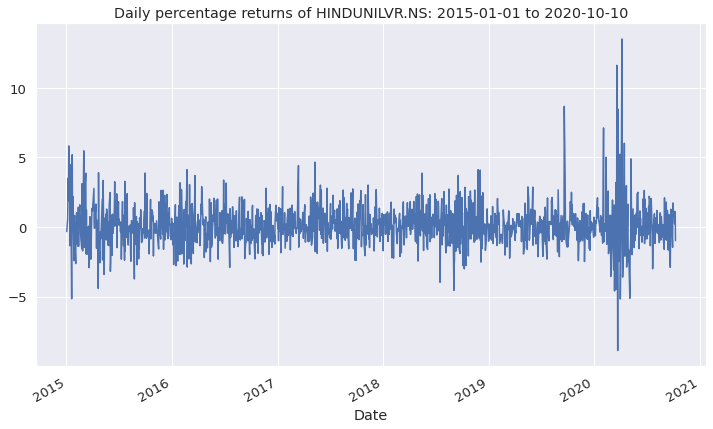

In [125]:
simple_perc_returns.plot(title=f'Daily percentage returns of {ticker10}: {start10} to {end10}', figsize=(12, 7))

In [126]:
import arch

# Specifying an ARCH(1) model 
arch_model1 = arch.arch_model(simple_perc_returns, vol='ARCH', mean="Zero", p=1, o=0, q=0)

# Estimating the model
arch_model1_fitted = arch_model1.fit()

# Printing the summary
print(arch_model1_fitted.summary())

Iteration:      1,   Func. Count:      4,   Neg. LLF: 2628.8145812526736
Iteration:      2,   Func. Count:      9,   Neg. LLF: 2588.8372891888403
Iteration:      3,   Func. Count:     15,   Neg. LLF: 2549.270264253323
Iteration:      4,   Func. Count:     17,   Neg. LLF: 2549.2702642532176
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2549.270264253323
            Iterations: 4
            Function evaluations: 17
            Gradient evaluations: 4
                        Zero Mean - ARCH Model Results                        
Dep. Variable:              adj_close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -2549.27
Distribution:                  Normal   AIC:                           5102.54
Method:            Maximum Likelihood   BIC:                           5113.06
                            

In [127]:
# one-period out-of-sample forecast
arch_model1_forecast = arch_model1_fitted.forecast(horizon=1)
print(arch_model1_forecast.mean['h.1'].iloc[-1])

0.0


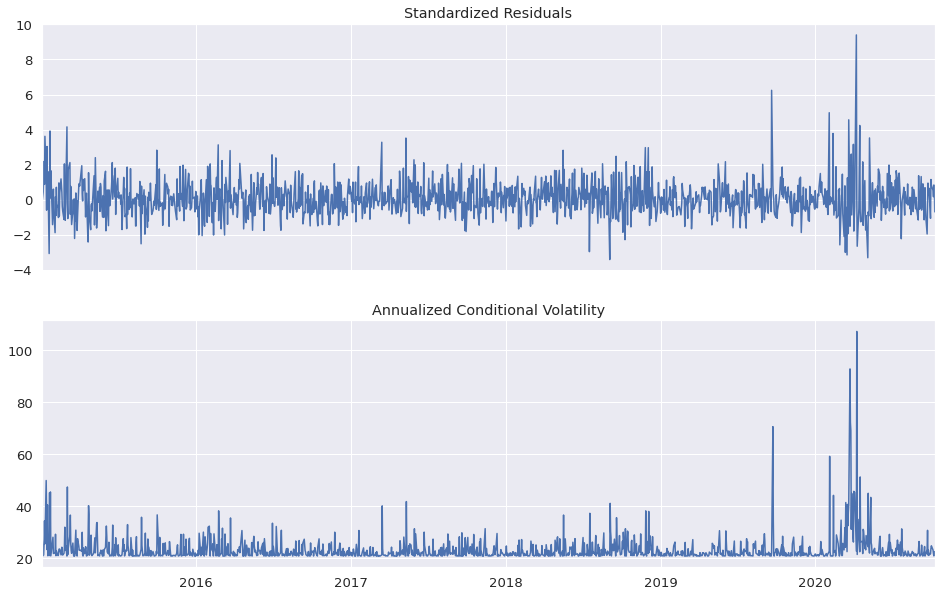

In [128]:
arch_model1_fitted.plot(annualize='D');

In [129]:
# Specifying a GARCH(1, 1) model 
garch_model1 = arch.arch_model(simple_perc_returns, vol='GARCH', mean="Zero", p=1, o=0, q=1)

# Estimating the model
garch_model1_fitted = garch_model1.fit()

# Printing the summary
print(garch_model1_fitted.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 801220849.7300324
Iteration:      2,   Func. Count:     12,   Neg. LLF: 2632.2148970776448
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2720.7100526677423
Iteration:      4,   Func. Count:     27,   Neg. LLF: 2465.596429698175
Iteration:      5,   Func. Count:     31,   Neg. LLF: 2465.588325954712
Iteration:      6,   Func. Count:     35,   Neg. LLF: 2465.587502477157
Iteration:      7,   Func. Count:     39,   Neg. LLF: 2465.5874296880293
Iteration:      8,   Func. Count:     43,   Neg. LLF: 2465.5874287387805
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2465.5874287387805
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8
                       Zero Mean - GARCH Model Results                        
Dep. Variable:              adj_close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared

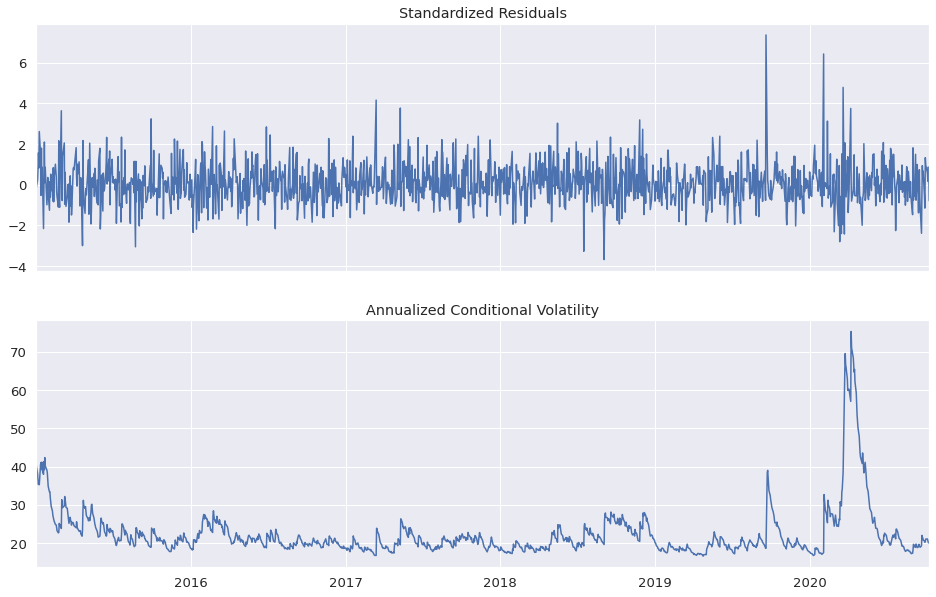

In [130]:
garch_model1_fitted.plot(annualize='D');

In [131]:
%%time

import pmdarima as pm

## fitting ARIMA on adjusted close prices
arima_fit_10 = pm.auto_arima(df10['adj_close'], error_action='ignore', 
                           suppress_warnings=True, seasonal=False)

p, d, q = arima_fit_10.order
print(p, d, q)
arima_fit_residuals = arima_fit_10.arima_res_.resid

# fitting a GARCH(1,1) model after fitting ARIMA on the prices
garch_model_2 = arch.arch_model(arima_fit_residuals, p=1, o=0, q=1)
garch_model2_fitted = garch_model_2.fit()

# Using ARIMA to predict prices
predicted_prices = arima_fit_10.predict(n_periods=1)[0]

# Using GARCH to predict the residuals
garch_model_2_forecast = garch_model2_fitted.forecast(horizon=1)
predicted_residual = garch_model_2_forecast.mean['h.1'].iloc[-1]
# Combining both models
predicted_price_range = (predicted_prices-predicted_residual, predicted_prices+predicted_residual)

print(predicted_price_range)

5 1 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 40292.36795868582
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7959.422263589962
Iteration:      3,   Func. Count:     21,   Neg. LLF: 7105.054444377288
Iteration:      4,   Func. Count:     27,   Neg. LLF: 6074.660811997865
Iteration:      5,   Func. Count:     32,   Neg. LLF: 6073.520055523298
Iteration:      6,   Func. Count:     37,   Neg. LLF: 6073.245077408341
Iteration:      7,   Func. Count:     42,   Neg. LLF: 6073.226230708942
Iteration:      8,   Func. Count:     47,   Neg. LLF: 6073.213244998704
Iteration:      9,   Func. Count:     52,   Neg. LLF: 6073.213211001281
Iteration:     10,   Func. Count:     57,   Neg. LLF: 6073.213205216359
Iteration:     11,   Func. Count:     62,   Neg. LLF: 6073.213204874465
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6073.213204874465
            Iterations: 11
            Function evaluations: 62
            Gradient evaluatio

<a id = 'references'></a>
#### References
<a id = 'bnshephard'></a>
<a id = 'arch'></a>
<a id = 'others'></a>
<a id = 'eryk'></a>
<a id = 'cont2001'></a>
<a id = 'hyndman'></a>

1. Brownlee, Jason. Introduction to time series forecasting with python: how to prepare data and develop models to predict the future. Machine Learning Mastery (2018).
2. Cochrane, John H. "Time series for macroeconomics and finance." Manuscript, University of Chicago (2005).
3. Cont, R. Empirical properties of asset returns: stylized facts and statistical issues (2001).
4. https://towardsdatascience.com/@eryk.lewinson
5. https://pyflux.readthedocs.io/en/latest/getting_started.html
6. https://tomaugspurger.github.io/modern-7-timeseries
7. https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html
8. https://www.statsmodels.org/devel/examples/notebooks/generated/exponential_smoothing.html
9. Hyndman, R.J., & Athanasopoulos, G. Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 11 July 2020.
6. Tsay, Ruey S. Analysis of financial time series. Vol. 543. John Wiley & Sons (2005).
7. Campbell, John Y., Andrew Wen-Chuan Lo, and Craig MacKinlay. The Econometrics of Financial Markets. Vol. 2. Princeton, NJ: princeton University press (1997).
10. http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016